In [37]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU memory: 4.3 GB


In [38]:
class ModelNetCustomDataset(Dataset):
    def __init__(self, train: bool, classes=None, debug=True):
        self.debug = debug
        
        if train:
            x = torch.load("../data/ModelNet_subset/train_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/train_y.pt", weights_only=True)
        else:
            x = torch.load("../data/ModelNet_subset/test_x.pt", weights_only=True)
            y = torch.load("../data/ModelNet_subset/test_y.pt", weights_only=True)

        # Load class names
        raw_dir = r"C:\Users\snevi\OneDrive\Documents\coding\AI\deep_learning\data\ModelNet\raw"
        self.class_names = sorted([
            name for name in os.listdir(raw_dir)
            if os.path.isdir(os.path.join(raw_dir, name))
        ])

        # Initialize mappings
        self.class_mapping = None
        self.reverse_mapping = None
        self.original_classes = classes

        if self.debug:
            print(f"Original data shapes: x={x.shape}, y={y.shape}")
            print(f"Original label range: [{y.min()}, {y.max()}]")
            print(f"Classes to filter: {classes}")

        # Filter classes FIRST, then standardize the filtered data
        if classes is not None:
            x, y = self.filter_classes(x, y, classes)
            
            if self.debug:
                print(f"After filtering: x={x.shape}, y={y.shape}")
                print(f"Filtered label range: [{y.min()}, {y.max()}]")

            # Create mapping from original class IDs to new contiguous IDs
            self.class_mapping = {original_id: new_id for new_id, original_id in enumerate(sorted(classes))}
            self.reverse_mapping = {new_id: original_id for original_id, new_id in self.class_mapping.items()}
            
            if self.debug:
                print(f"Class mapping: {self.class_mapping}")
            
            # Remap class IDs to be contiguous [0, 1, 2, ..., len(classes)-1]
            y = self.remap_classes(y)
            
            if self.debug:
                print(f"After remapping: label range [{y.min()}, {y.max()}]")
                print(f"Expected range: [0, {len(classes)-1}]")

        # Apply standardization to the (potentially filtered) data
        self.x = self.standardise(x)
        self.y = y
        
        if self.debug:
            print(f"Final dataset: x={self.x.shape}, y={self.y.shape}")
            print(f"Final label range: [{self.y.min()}, {self.y.max()}]")
        
    def remap_classes(self, y):
        """Remap original class IDs to contiguous range [0, 1, 2, ...]"""
        y_remapped = torch.zeros_like(y)
        for i in range(len(y)):
            original_class = y[i].item()
            if original_class not in self.class_mapping:
                raise ValueError(f"Class {original_class} not found in mapping {self.class_mapping}")
            new_class = self.class_mapping[original_class]
            y_remapped[i] = new_class
        return y_remapped

    def standardise(self, x):
        standardised_data = torch.zeros_like(x)
        for i in range(x.shape[0]):
            obj = x[i]
            mean_x = obj.mean(dim=0)
            std_x = obj.std()
            standardised_data[i] = (obj - mean_x) / (std_x + 1e-8)
        return standardised_data

    def filter_classes(self, x, y, classes):
        indices_to_keep = []
        for idx in range(len(y)):
            if y[idx].item() in classes:
                indices_to_keep.append(idx)
        
        if len(indices_to_keep) == 0:
            raise ValueError(f"No samples found for classes {classes}")
        
        x_selected = torch.index_select(x, dim=0, index=torch.tensor(indices_to_keep))
        y_selected = torch.index_select(y, dim=0, index=torch.tensor(indices_to_keep))
        return x_selected, y_selected

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        point_cloud = self.x[idx]
        class_id = self.y[idx]

        # Get original class name using reverse mapping
        if self.reverse_mapping is not None:
            original_class_id = self.reverse_mapping[class_id.item()]
            label = self.class_names[original_class_id]
        else:
            label = self.class_names[class_id.item()]
        
        return point_cloud, class_id, label

In [39]:
#selected_classes = [0, 5, 6, 7, 8, 10, 19, 24, 26, 30, 32, 33, 34, 35, 37]
all_classes = [i for i in range(0,40)]
poor_classes = [24,39,1,21,36,12,23,3,10,15,11,38,29,13,27]
selected_classes = [i for i in all_classes if i not in poor_classes]
NUM_CLASSES = len(selected_classes)
train_dataset = ModelNetCustomDataset(train=True, classes=selected_classes, debug=False)
test_dataset = ModelNetCustomDataset(train=False, classes=selected_classes, debug=False)

BATCH_SIZE = 32
EPOCHS = 20
INPUT_SHAPE = (200, 3)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

## models

In [40]:
class SimpleBaseline(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units), 
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x): 
        return self.layer_stack(x)

# Model parameters
model = SimpleBaseline(
    input_shape=INPUT_SHAPE[0] * INPUT_SHAPE[1],
    hidden_units=128,
    output_shape=NUM_CLASSES
)

print(f"Model created with:")
print(f"   Input shape: {INPUT_SHAPE[0] * INPUT_SHAPE[1]} (flattened from {INPUT_SHAPE})")
print(f"   Hidden units: 128")
print(f"   Output classes: {NUM_CLASSES}")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model created with:
   Input shape: 600 (flattened from (200, 3))
   Hidden units: 128
   Output classes: 25
   Model parameters: 80,153


In [41]:
class SingleHeadSelfAttention(nn.Module):
    """
    x: (B, N, E)
      E = embed_dim (input feature size per token)
      d_k = query/key size
      d_v = value size (can differ from d_k)
    Returns: (B, N, out_dim) where out_dim defaults to d_v unless specified.
    """
    def __init__(self,
                 embed_dim: int,
                 d_k: int,
                 d_v: int,
                 out_dim: int | None = None,
                 p_drop: float = 0.0):
        super().__init__()
        self.q_proj = nn.Linear(embed_dim, d_k)
        self.k_proj = nn.Linear(embed_dim, d_k)
        self.v_proj = nn.Linear(embed_dim, d_v)

        # if want to keep the same width as the rest of the model (e.g., embed_dim), set out_dim=embed_dim; otherwise it will output size d_v.
        self.out_dim = d_v if out_dim is None else out_dim
        self.out_proj = (
            nn.Identity() if self.out_dim == d_v else nn.Linear(d_v, self.out_dim)
        )

        #/ torch.sqrt(torch.tensor(self.hidden_dim)) creates new CPU tensor every forward
        self.scale = 1.0 / math.sqrt(d_k)  # scale by sqrt(d_k) (constant scaling factor)

        #dropout for attention probabilities - randomly zeroes fraction p and rescales rest by 1/(1-p) (Pytorch inverted dropout)
        #encourages model not to rely on single sharp attention pattern to improve generalisation
        self.attn_drop = nn.Dropout(p_drop)

        #feature dropout on per-token features produced by attention - randomly zeros elements of output vectors
        self.proj_drop = nn.Dropout(p_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, E)
        q = self.q_proj(x)                     # (B, N, d_k)
        k = self.k_proj(x)                     # (B, N, d_k)
        v = self.v_proj(x)                     # (B, N, d_v)

        #calculate attention weights
        # k.T flips all dims, including batch -> only need to transpose last two dims
        # k:(B,N,H) -> k.T:(H,N,B), but k.transpose(-2,-1): (B,H,N)
        # (B,N,H) @ (B,H,N) -> (B,N,N)
        scores = (q @ k.transpose(-2, -1)) * self.scale  # (B, N, N)
        attn = torch.softmax(scores, dim=-1)             # (B, N, N)
        attn = self.attn_drop(attn)

        y = attn @ v                                     # (B, N, d_v)
        y = self.out_proj(y)                             # (B, N, out_dim)
        y = self.proj_drop(y)
        return y

In [42]:
class SingleHeadClassifier(nn.Module):
    """
    Minimal single-head attention classifier for point clouds.
    Input: (B, N, 3)

    -- attn(d_k,d_v,out_dim) --> (B,N,out_dim)
    -- mean pooling --> (B,out_dim)
    -- linear --> (B, num_classes)

    Output: (B, num_classes) logits
    """
    def __init__(self, 
            num_classes:int,
            embed_dim: int = 64,
            d_k: int = 64,
            d_v: int = 64,
            out_dim: int = 64,
            p_drop: float = 0.1):
        
        super().__init__()

        #takes each point's raw coords (x,y,z) and lifts them into richer feature space of size embed_dim
        #3 numbers too limited for attention to learn useful relations
        #small MLP creates more expressive per-point features


        self.embed=nn.Sequential(
            nn.Linear(3,embed_dim),

            #GELU = Gaussian Error Linear Unit = smooth activarion, like ReLU but with smoother graident
            nn.GELU(),
            nn.Linear(embed_dim,embed_dim)
        )

        self.attn = SingleHeadSelfAttention(
            embed_dim=embed_dim, d_k=d_k, d_v=d_v, out_dim=out_dim, p_drop=p_drop
        )

        #if ever switch back to mean-only, change the head to nn.Linear(out_dim, num_classes)
        self.head = nn.Linear(2 * out_dim, num_classes) 

    def forward(self, x):
        x=self.embed(x)         # (B, N, embed_dim)
        x = self.attn(x)            # (B, N, out_dim)

        #mean pool over points, averages over N points
        #symmetric reduction - permutation-invariant as reordering points does not change mean - important as point cloud is an unordered set
        #smooth, noise tolerant summary
        feat_mean = x.mean(dim=1)        # (B, out_dim) 

        #max pool over points, takes max over N points
        #takes strongest activation per channel to pick out edge like features
        feat_max = x.amax(dim=1)   # (B, out_dim)

        #global pooling - fuses smooth global trends and extremes -> gives small accuracy boost
        feat = torch.cat([feat_mean,feat_max],dim=-1) # (B, 2*out_dim)

        #pooled feature goes through linear layer to produce class logits suitable for nn.CrossEntropyLoss
        logits = self.head(feat)    # (B, num_classes)
        return logits


In [ ]:
single_model = SingleHeadClassifier(
    num_classes=NUM_CLASSES,
    d_k=128, d_v=128, out_dim=128,   
    p_drop=0.1
).to(device)

In [44]:
class MultiHeadAttention(nn.Module):
    """
    x: (B, N, D)
        N = num of features
        D = dim of model
    Returns: (B, N, D) where D = out_dim
    """
    def __init__(self,
            dim:int,
            num_heads:int,
            #p_drop: float = 0.0
        ):
        super().__init__()

        self.dim=dim #dim of input
        self.num_heads=num_heads
        
        self.d_k=dim//num_heads #D//h = Dimension of each head's key, query, and value

        self.W_q=nn.Linear(dim,dim) 
        self.W_k=nn.Linear(dim,dim)
        self.W_v=nn.Linear(dim,dim)

        self.W_y=nn.Linear(dim,dim) #output transformation

    def split_heads(self,x):
        batch,n,dim=x.size()
        x_split=x.reshape(batch,n,self.num_heads,self.d_k).transpose(-3,-2)
        return x_split

    def combine_heads(self,x_split):
        batch,num_heads,n,d_k=x_split.size()
        x_final = x_split.reshape(batch,n,self.dim)
        return x_final

    def scaled_dot_product_attention(self,q_split,k_split,v_split):
        #calculate attention weights
        # k.T flips all dims, including batch -> only need to transpose last two dims
        # k:(B,N,D) -> k.T:(D,N,B)
        # (B,N,D) @ (B,D,N) -> (B,N,N)

        k_split_T = k_split.transpose(-2,-1)
        attn_scores = torch.matmul(q_split,k_split_T) / math.sqrt(self.d_k)
        attn_probs = torch.softmax(attn_scores,dim=-1)
        y_split = torch.matmul(attn_probs,v_split)

        return y_split

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        q_split = self.split_heads(self.W_q(x))                     # (B, N, D) -> (B, h, N, D/h)
        k_split = self.split_heads(self.W_k(x))                     # (B, N, D) -> (B, h, N, D/h)
        v_split = self.split_heads(self.W_v(x))                     # (B, N, D) -> (B, h, N, D/h)

        y_split=self.scaled_dot_product_attention(q_split,k_split,v_split)
        y=self.W_y(self.combine_heads(y_split))

        return y

In [45]:
class MultiHeadClassifier(nn.Module):
    """
    attention classifier for point clouds.
    Input: (B, N, 3)

    -- attn(d_k,d_v,out_dim) --> (B,N,D)
    -- mean pooling --> (B,D)
    -- linear --> (B, num_classes)

    Output: (B, num_classes) logits
    """
    def __init__(self, 
            num_classes:int,
            embed_dim:int =64,
            num_heads:int=8,
            p_drop: float = 0.1):
        
        super().__init__()

        #takes each point's raw coords (x,y,z) and lifts them into richer feature space of size embed_dim
        #3 numbers too limited for attention to learn useful relations
        #small MLP creates more expressive per-point features


        self.embed=nn.Sequential(
            nn.Linear(3,embed_dim),
            nn.ReLU()
        )

        self.attn = MultiHeadAttention(
            dim=embed_dim,
            num_heads=num_heads
        #,p_drop=p_drop
        )

        #if ever switch back to mean-only, change the head to nn.Linear(out_dim, num_classes)
        self.head = nn.Linear(embed_dim, num_classes) 

    def forward(self, x):
        x=self.embed(x)         # (B, N, embed_dim)
        x=self.attn(x)            # (B, N, out_dim)

        #mean pool over points, averages over N points
        #symmetric reduction - permutation-invariant as reordering points does not change mean - important as point cloud is an unordered set
        #smooth, noise tolerant summary
        feat_mean = x.mean(dim=1)        # (B, D) 

        #max pool over points, takes max over N points
        #takes strongest activation per channel to pick out edge like features
        # feat_max = x.amax(dim=1)   # (B, out_dim)

        #global pooling - fuses smooth global trends and extremes -> gives small accuracy boost
        #feat = torch.cat([feat_mean,feat_max],dim=-1) # (B, 2*out_dim)

        #pooled feature goes through linear layer to produce class logits suitable for nn.CrossEntropyLoss
        logits = self.head(feat_mean)    # (B, num_classes)
        return logits

In [ ]:
multi_attention_model = MultiHeadClassifier(
    num_classes=NUM_CLASSES, embed_dim=256, num_heads=16,
    p_drop=0.2
).to(device)

## steps

In [47]:
def accuracy_fn(y_pred,y_true):
    """
    Calculate accuracy of predictions
    Args:
        y_pred: Predictions from model (logits)
        y_true: True labels
    Returns:
        Accuracy as a percentage
    """
    # Get predicted class indices by taking argmax along the last dimension
    y_pred_indices = torch.argmax(y_pred, dim=1)
    
    # Compare with true labels and calculate accuracy
    correct = (y_pred_indices == y_true).sum().item()
    total = y_true.size(0)
    
    return correct / total * 100  # Return accuracy as percentage

In [48]:
def train_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        optimiser: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True):

    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    #print(f"training loop on {device}...")
    
    for batch, (X, y, names) in enumerate(data_loader):
        
        try:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Fix label shape
            if y.dim() > 1:
                y = y.squeeze()
            y=y.long()

            # Forward pass
            y_pred = model(X)
            
            # Loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred, y)
            
            train_loss += loss.item()
            train_acc += acc
            
            # Backward
            optimiser.zero_grad()
            loss.backward()
            
            # Update
            optimiser.step()
            
        except Exception as e:
            print(f"   Error in batch {batch + 1}: {e}")
            import traceback
            traceback.print_exc()
            break
    
    # Calculate averages
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if verbose == True:
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc


In [49]:
def test_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True
):
        test_loss, test_acc = 0, 0
        model.to(device)
        model.eval()  # Set model to evaluation mode
        with torch.inference_mode():  # No gradients needed for inference
            try:
                for batch, (X, y, names) in enumerate(data_loader):
                    X, y = X.to(device), y.to(device)

                    if y.dim() > 1:
                        y = y.squeeze()  # Converts [64, 1] to [64]
                    y=y.long()
                    
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y)
                    acc = accuracy_fn(y_pred, y)

                    test_loss += loss.item()
                    test_acc += acc

            except Exception as e:
                print(f"   Error in batch {batch + 1}: {e}")
                import traceback
                traceback.print_exc()

            # Average loss per batch per epoch
            test_loss /= len(data_loader)
            test_acc /= len(data_loader)
            if verbose == True:
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc

In [50]:
def train_model(model,epochs, verbose = True):
    train_accs,test_accs,train_losses,test_losses=[],[],[],[]
    loss_fn= nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Added weight decay for regularisation

    # Use tqdm only if verbose is True
    epoch_iterator = tqdm(range(epochs)) if verbose else range(epochs)
    
    for epoch in epoch_iterator:
        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    if not verbose:
        print(f"Final: Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_accs[-1]:.2f}%")
    

    return train_accs, test_accs, train_losses, test_losses


In [51]:
def plot_acc_losses(
        model_name: str,
        train_accs: list,
        test_accs: list,
        train_losses: list,
        test_losses: list,
        epochs: int = 7
):
        f,(ax1,ax2)=plt.subplots(1,2)
        f.set_size_inches(15,5)
        ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
        ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
        ax1.set_title(f"{model_name} Accuracies")
        ax1.legend()
        ax1.set_ylabel("Accuracies (%)")
        ax1.set_xlabel("Epochs")

        ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
        ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
        ax2.set_title(f"{model_name} Losses")
        ax2.legend()
        ax2.set_ylabel("Losses")
        ax2.set_xlabel("Epochs")
    

## test

In [52]:
(baseline_train_accs, baseline_test_accs,
    baseline_train_losses, baseline_test_losses) = train_model(model, epochs=10,verbose=False)

Final: Train Acc: 95.70%, Test Acc: 22.39%


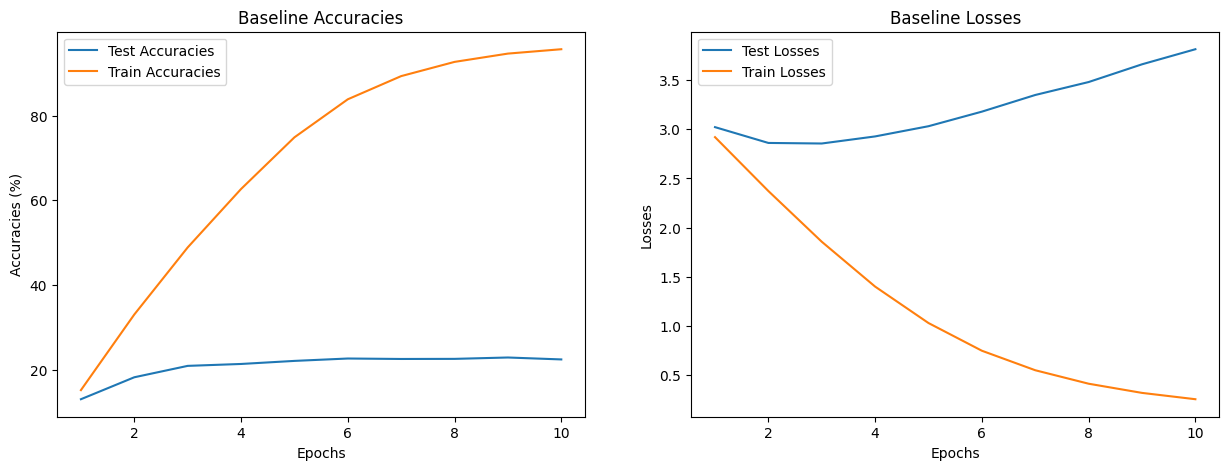

In [53]:
plot_acc_losses(
    model_name="Baseline",
    train_accs=baseline_train_accs,
    test_accs=baseline_test_accs,
    train_losses=baseline_train_losses,
    test_losses=baseline_test_losses,
    epochs=10
)

In [54]:
(train_accs, test_accs,
 train_losses, test_losses) = train_model(attention_model, epochs=EPOCHS,verbose=False)

Final: Train Acc: 84.43%, Test Acc: 80.59%


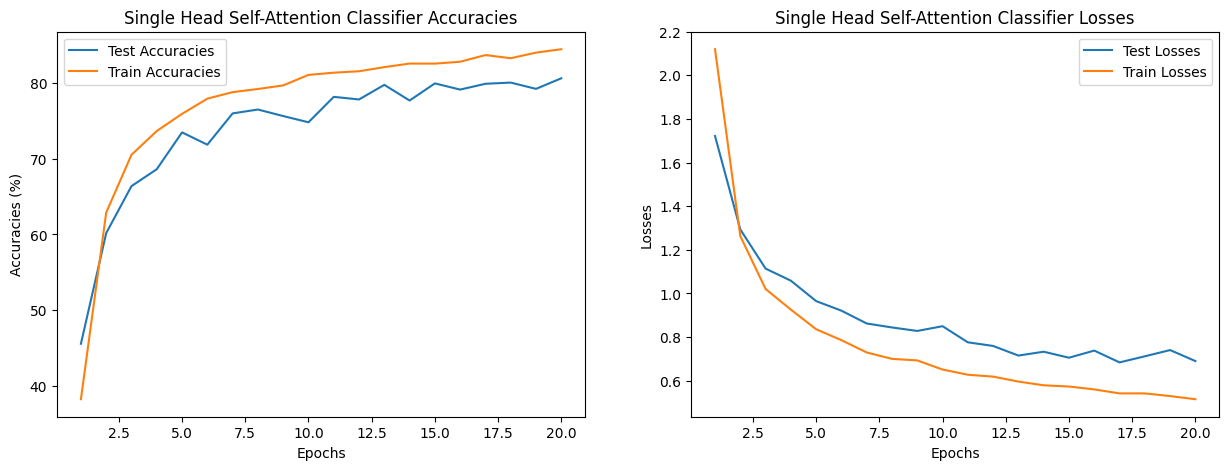

In [55]:
plot_acc_losses(
    model_name="Single Head Self-Attention Classifier",
    train_accs=train_accs,
    test_accs=test_accs,
    train_losses=train_losses,
    test_losses=test_losses,
    epochs=EPOCHS
)

In [56]:
(train_accs, test_accs,
 train_losses, test_losses) = train_model(attention_model, epochs=EPOCHS,verbose=False)

KeyboardInterrupt: 

In [ ]:
plot_acc_losses(
    model_name="Multi Head Attention Classifier",
    train_accs=train_accs,
    test_accs=test_accs,
    train_losses=train_losses,
    test_losses=test_losses,
    epochs=EPOCHS
)